In [5]:
from Module.ICSS import *
from Module.sat_info_load import *
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [6]:
def detect_ol(hour_df, XY_Maneuvering):
    # Maneuvering 별 이상치탐지 DataFrame 생성.
    ol_all_infos = []
    if XY_Maneuvering:
        col_lst = ['Eccentricity', 'Semi-Major Axis(km)']
        for col in col_lst:
            diff_value = np.log(hour_df[col]).diff().fillna(0).values
            for level in [95, 99]:
                for window in [24 * 5, 24 * 10]:
                    temp = [col, level, window, 'ON']
                    print(f'window : {window}, level : {level}')
                    temp.extend(ol_detect(hour_df, diff_value, window, level))
                    ol_all_infos.append(temp)

    if not XY_Maneuvering:
        col_lst = ['Inclination(deg)', 'RAAN(deg)']
        for col in col_lst:
            diff_value = np.log(hour_df[col]).diff().fillna(0).values
            for level in [95, 99]:
                for window in [24 * 5, 24 * 10]:
                    temp = [col, level, window, 'ON']
                    print(f'window : {window}, level : {level}')
                    temp.extend(ol_detect(hour_df, diff_value, window, level))
                    ol_all_infos.append(temp)

    temp_df = pd.DataFrame(ol_all_infos).astype('str')
    return temp_df, col_lst

In [7]:
def plot_graph(number, hour_df, temp_df: pd.DataFrame, col_lst, start_date: str, end_date: str):
    '''
    :param hour_df: 시간 단위로 추출된 통계량 DataFrame
    :param XY_Maneuvering: XY maneuvering 인지 Z maneuvering 인지 여부
    :param start_date: 그래프의 시작날짜
    :param end_date: 그래프의 종료날짜 
    :return: 그래프 출력
    '''

    # 이상치탐지 DataFrame으로 그래프 출력
    for i in range(4):
        # 두 가지 통계량에서 모두 탐지된 이상치만 True 이상치로 분류
        first_lst = temp_df.iloc[i][4:]
        second_lst = temp_df.iloc[i + 4][4:]
        co_ol_lst = [pd.to_datetime(ol) for ol in list(set(first_lst) & set(second_lst)) if ol != 'NaT']
        co_ol_lst.sort()
        print(list(temp_df.iloc[i][1:4])[0] + '% threshold, ' + list(temp_df.iloc[i][1:4])[1] + 'hours')
        # print(co_ol_lst)

        # 첫번째 통계량의 그래프를 출력
        fig, ax1 = plt.subplots(figsize=(10, 1.5), dpi=400)
        ax1.plot(hour_df[temp_df.iloc[i][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i][0]].index) & (
                hour_df[temp_df.iloc[i][0]].index <= pd.to_datetime(end_date))],
                 color=(40 / 255, 217 / 255, 9 / 255), label=temp_df.iloc[i][0])
        ax1.set_xlabel('Date')
        ax1.set_ylabel(temp_df.iloc[i][0], fontsize=9, color=(40 / 255, 217 / 255, 9 / 255))
        ax1.tick_params(axis='y', colors=(40 / 255, 217 / 255, 9 / 255))

        # 두번째 통계량의 그래프를 출력
        ax2 = ax1.twinx()
        ax2.plot(
            hour_df[temp_df.iloc[i + 4][0]][(pd.to_datetime(start_date) <= hour_df[temp_df.iloc[i + 4][0]].index) & (
                    hour_df[temp_df.iloc[i + 4][0]].index <= pd.to_datetime(end_date))], color=(0, 0, 1),
            label=temp_df.iloc[i + 4][0])
        ax2.set_ylabel(temp_df.iloc[i + 4][0], fontsize=9, color=(0, 0, 1))
        ax2.tick_params(axis='y', colors=(0, 0, 1))
        formatter = ticker.ScalarFormatter(useOffset=False)
        ax2.yaxis.set_major_formatter(formatter)

        # 이상치를 위 그래프 위에 표시
        for point in co_ol_lst:
            if (pd.to_datetime(start_date) <= point) & (point <= pd.to_datetime(end_date)):
                plt.axvline(point, color=(1, 0, 0), linewidth=1, linestyle='--', label="Detected Maneuver using TLE")  #
                ax1.scatter(point, hour_df[col_lst[0]].loc[point], color=(1, 0, 0), s=10, zorder=5)
                ax2.scatter(point, hour_df[col_lst[1]].loc[point], color=(1, 0, 0), s=10, zorder=5)

        # plot의 범례 표시
        plt.xlabel('Date')
        handles1, labels1 = ax1.get_legend_handles_labels()
        handles2, labels2 = ax2.get_legend_handles_labels()
        handles = handles1 + handles2
        labels = labels1 + labels2
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.4))
        plt.savefig(f'File/images/{number}/{i}.png')
        # plt.show()

In [8]:
input_dir = 'Database'
output_dir = 'File/images'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)
number_lst = [42984]

# List of files that do not exist in the output directory
missing_dirs = [str(file) for file in number_lst if not os.path.exists(f"{output_dir}/{file}")]

# Create missing files
for directory in missing_dirs:
    dir_path = os.path.join(output_dir, directory)
    os.makedirs(dir_path)

print(f"Created {len(missing_dirs)} missing files in {output_dir}.")

Created 0 missing files in File/images.


In [9]:
# 위성번호 리스트
username = 'asas4539@hanyang.ac.kr'
password = 'onsaemiro1729!!'

# created time 기준으로 sorting 하면 True epoch time 기준으로 sorting 하면 False 
created_time = False
for number in number_lst:
    kvn_response, tle_response = get_tle(number, username, password)
    change_df = compute_change_df(kvn_response, tle_response, created_time)
    result = compute_result_df(change_df)
    print(f"result_df Shape: {result.shape}")
    result.to_csv(f'Database/{number}_epoch.csv')

100%|██████████| 1217/1217 [00:46<00:00, 26.05it/s]


result_df Shape: (833672, 22)


window : 120, level : 95


 28%|██▊       | 3909/13754 [00:00<00:02, 4288.06it/s]C:\Users\asas4\Documents\GitHub\SPACEMAP\Module\ICSS.py:31: RuntimeWarning: invalid value encountered in divide
  D_prime = (CUSUM - (k + 1) / T * CUSUM[-1]) / np.sqrt(lambda_hat)
100%|██████████| 13754/13754 [00:03<00:00, 4106.51it/s]


window : 240, level : 95


100%|██████████| 13634/13634 [00:03<00:00, 4119.55it/s]


window : 120, level : 99


100%|██████████| 13754/13754 [00:03<00:00, 4095.71it/s]


window : 240, level : 99


100%|██████████| 13634/13634 [00:03<00:00, 4204.86it/s]


window : 120, level : 95


100%|██████████| 13754/13754 [00:03<00:00, 4130.78it/s]


window : 240, level : 95


100%|██████████| 13634/13634 [00:03<00:00, 4127.35it/s]


window : 120, level : 99


100%|██████████| 13754/13754 [00:03<00:00, 4115.72it/s]


window : 240, level : 99


100%|██████████| 13634/13634 [00:03<00:00, 4119.41it/s]


95% threshold, 120hours


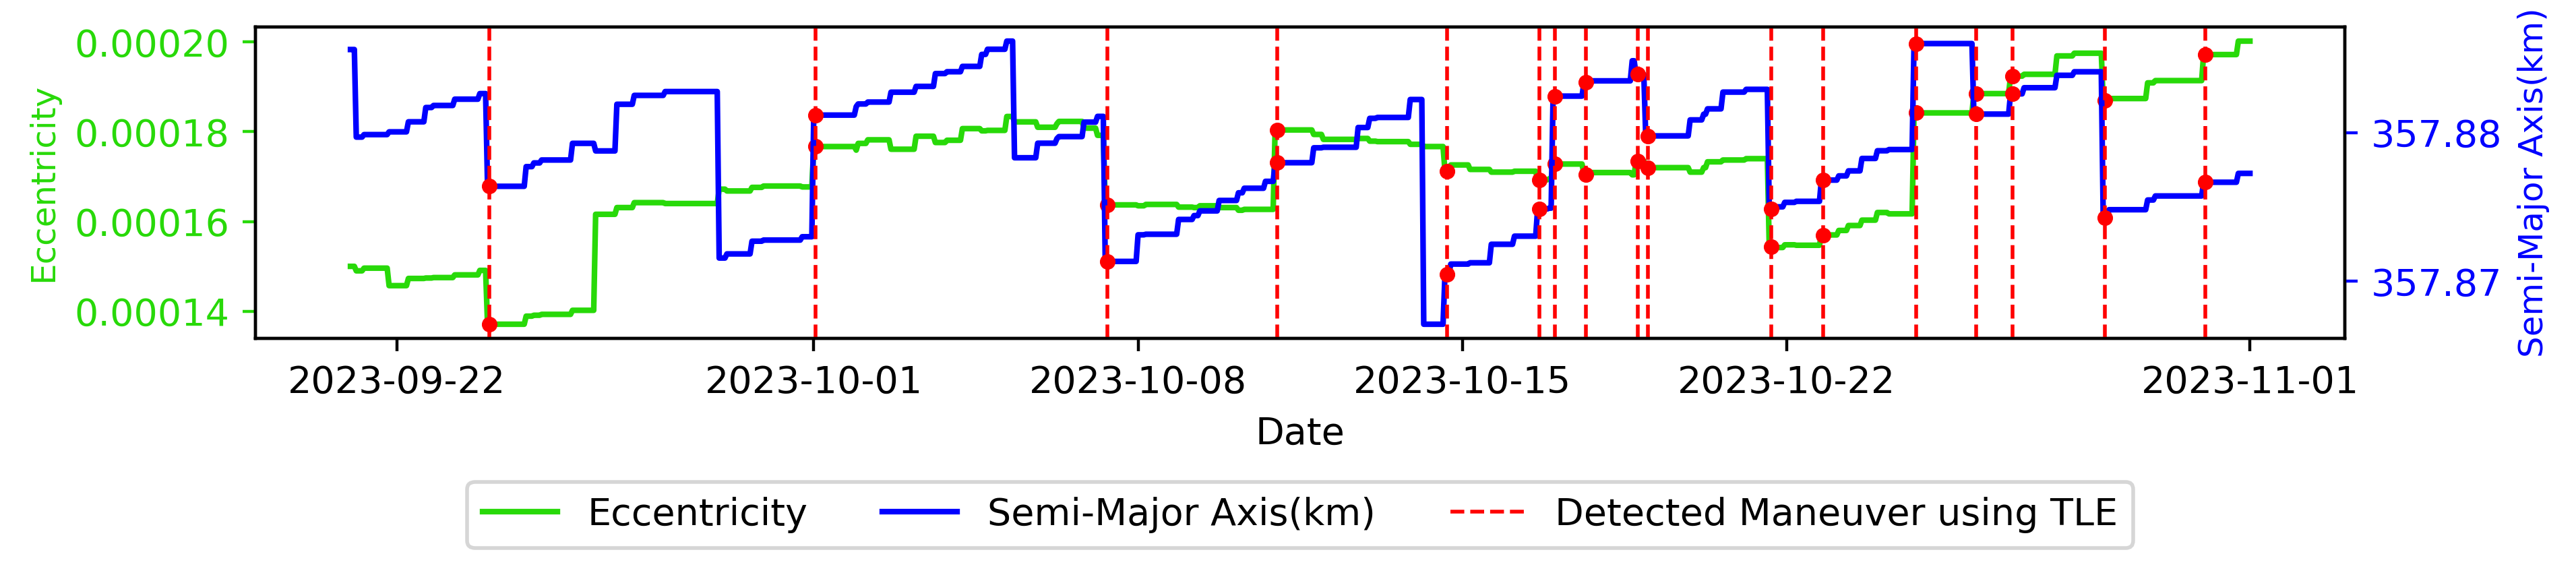

95% threshold, 240hours


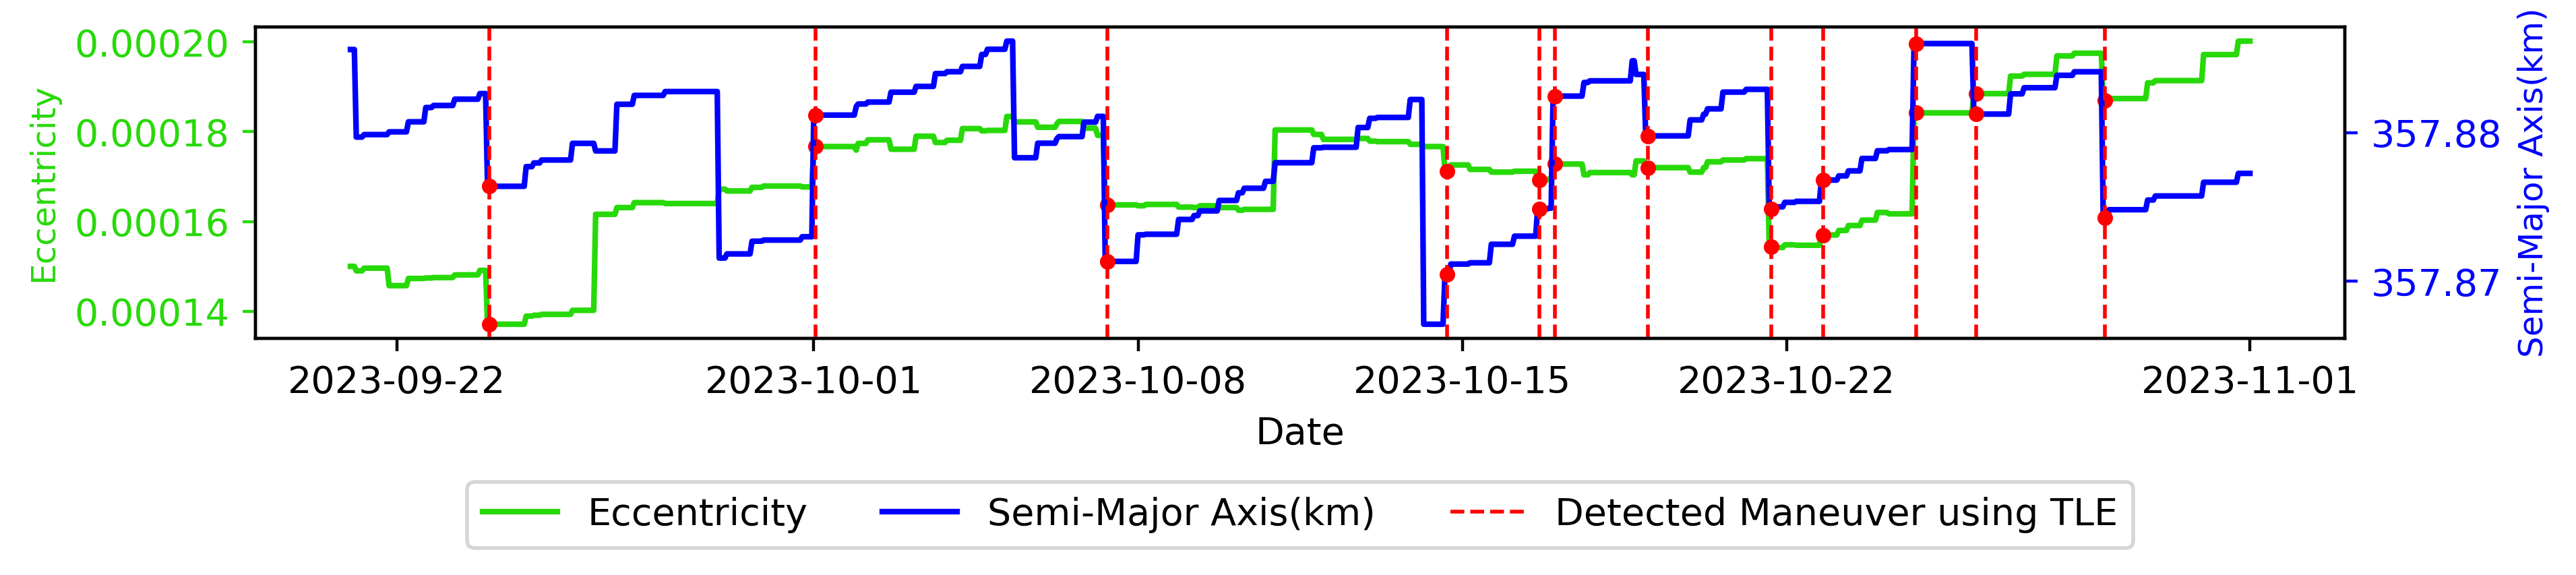

99% threshold, 120hours


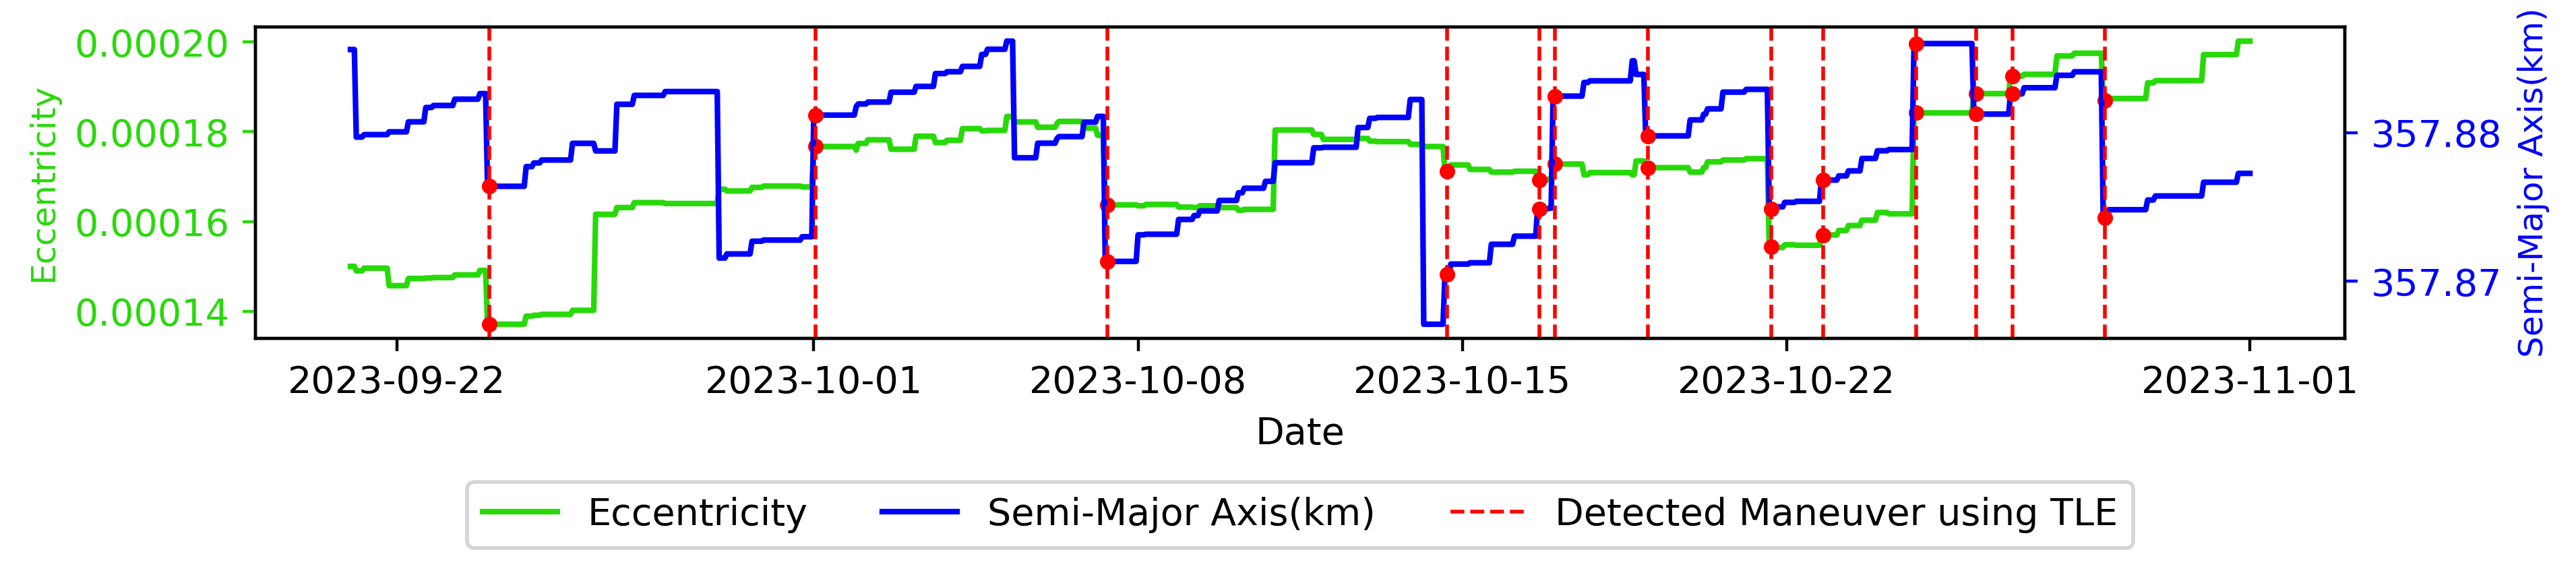

99% threshold, 240hours


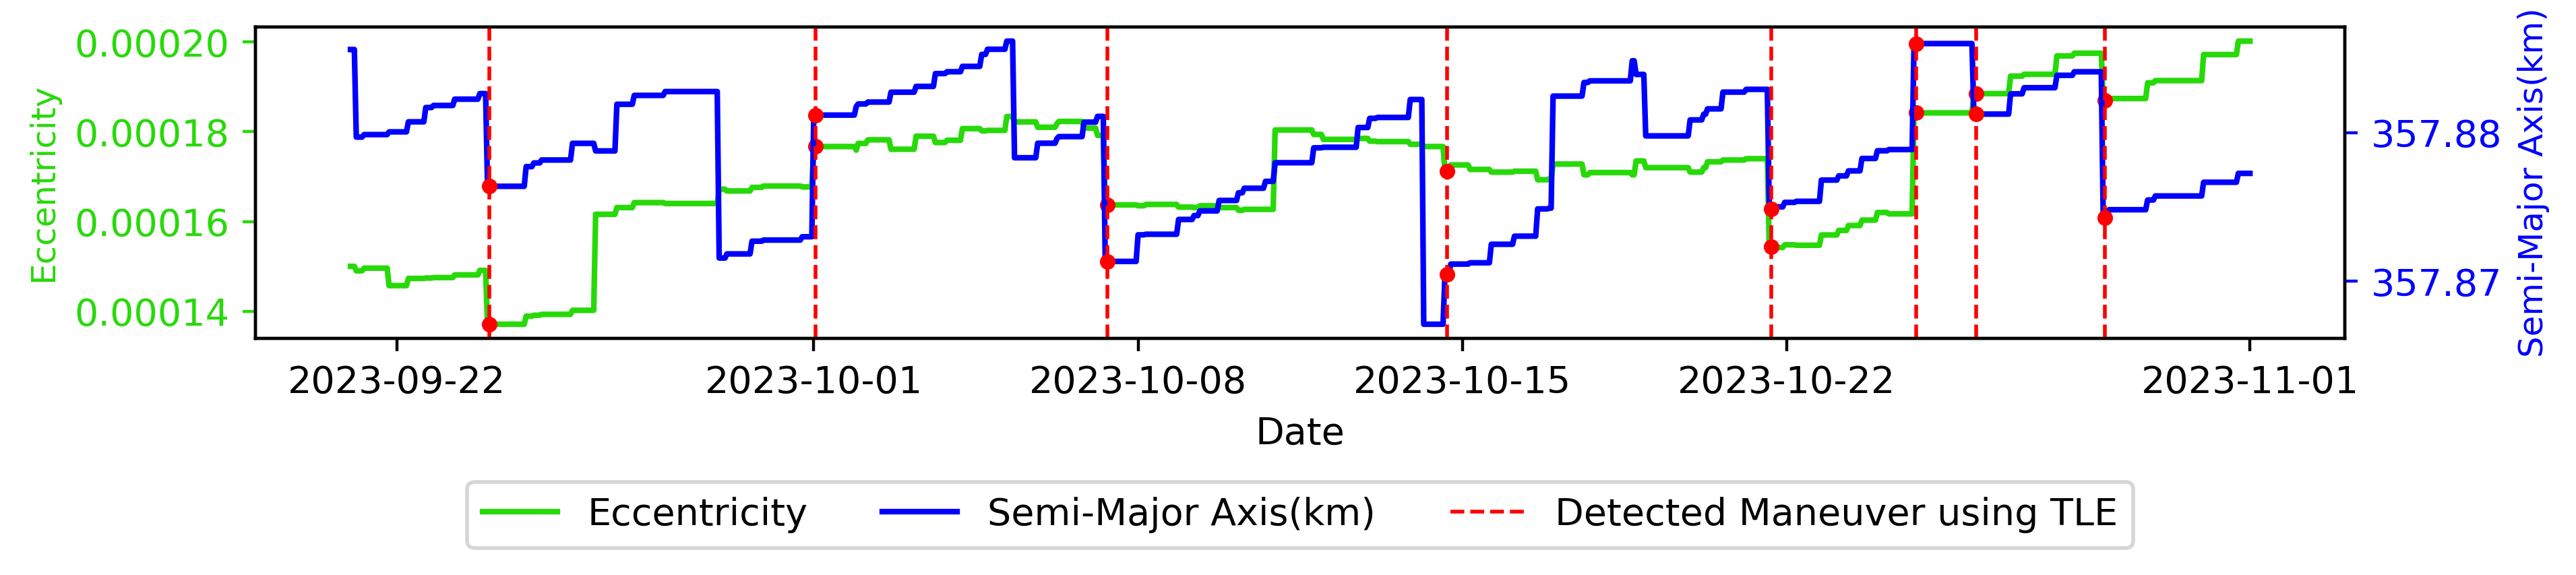

In [11]:
for num in number_lst:
    hour_df = load_data('Database', num, '2022-12-31 23:59:59', '2024-08-01 00:00:00', True)
    temp_df, col_lst = detect_ol(hour_df, True)
    plot_graph(num, hour_df, temp_df, col_lst, '2023-09-21', '2023-11-01')